In [1]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

from training_v2 import *

probtorch: 0.0+5a2c637 torch: 0.4.1 cuda: True


In [2]:
## Load dataset
data_path = "../rings_fixed_radius_c2k"
Data = torch.from_numpy(np.load(data_path + '/obs.npy')).float()
FIXED_RADIUS = 1.5

NUM_DATASETS, N, D = Data.shape
K = 3 ## number of clusters
SAMPLE_SIZE = 10
NUM_HIDDEN_GLOBAL = 8
NUM_HIDDEN_LOCAL = 64
NUM_HIDDEN_DEC = 64
NUM_STATS = 16

BATCH_SIZE = 20
NUM_EPOCHS = 1000
LEARNING_RATE = 1e-3
ONLY_FORWARD = True
CUDA = torch.cuda.is_available()
PATH = 'halo-ep-generative-onlyf-%dsamples' % (SAMPLE_SIZE)
DEVICE = torch.device('cuda:1')

obs_rad = torch.ones(1) * FIXED_RADIUS
noise_sigma = torch.ones(1) * 0.05
if CUDA:
    obs_rad = obs_rad.cuda().to(DEVICE)
    noise_sigma = noise_sigma.cuda().to(DEVICE)
Train_Params = (NUM_EPOCHS, NUM_DATASETS, SAMPLE_SIZE, BATCH_SIZE, CUDA, DEVICE, PATH)
Model_Params = (obs_rad, noise_sigma, N, K, D)

In [3]:
from local_enc import *
from global_oneshot import *
from decoder import *
## if reparameterize continuous variables
Reparameterized = False
# initialization
dec_x = Dec_x(D, NUM_HIDDEN_DEC, CUDA, DEVICE, Reparameterized)
enc_z = Enc_z(K, D, NUM_HIDDEN_LOCAL, CUDA, DEVICE)
oneshot_eta = Oneshot_mu(K, D, NUM_HIDDEN_GLOBAL, NUM_STATS, CUDA, DEVICE, Reparameterized)
if CUDA:
    dec_x.cuda().to(DEVICE)
    enc_z.cuda().to(DEVICE)
    oneshot_eta.cuda().to(DEVICE)
        
optimizer_enc =  torch.optim.Adam(list(oneshot_eta.parameters())+list(enc_z.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))
optimizer_dec =  torch.optim.Adam(list(dec_x.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))

models = (oneshot_eta, enc_z, dec_x)

In [4]:
from os_ep_v2 import *
train_v2(models, EP, optimizer_enc, optimizer_dec, Data, Model_Params, Train_Params)

epoch: 0\1000 (3s),  eubo: -668.601,  elbo: -734.195,  ess: 1.061
epoch: 1\1000 (3s),  eubo: -616.039,  elbo: -711.861,  ess: 1.047
epoch: 2\1000 (3s),  eubo: -660.644,  elbo: -750.237,  ess: 1.054
epoch: 3\1000 (3s),  eubo: -747.551,  elbo: -815.296,  ess: 1.062
epoch: 4\1000 (3s),  eubo: -576.624,  elbo: -711.332,  ess: 1.042
epoch: 5\1000 (3s),  eubo: -511.040,  elbo: -641.642,  ess: 1.035
epoch: 6\1000 (3s),  eubo: -418.162,  elbo: -554.799,  ess: 1.039
epoch: 7\1000 (3s),  eubo: -336.906,  elbo: -486.541,  ess: 1.038
epoch: 8\1000 (3s),  eubo: -269.543,  elbo: -413.804,  ess: 1.046
epoch: 9\1000 (3s),  eubo: -84.988,  elbo: -229.425,  ess: 1.045
epoch: 10\1000 (3s),  eubo: 134.204,  elbo: -14.477,  ess: 1.035
epoch: 11\1000 (3s),  eubo: -29.153,  elbo: -171.418,  ess: 1.049
epoch: 12\1000 (3s),  eubo: 48.219,  elbo: -68.443,  ess: 1.058
epoch: 13\1000 (3s),  eubo: 334.364,  elbo: 195.720,  ess: 1.050
epoch: 14\1000 (3s),  eubo: 728.715,  elbo: 585.013,  ess: 1.042
epoch: 15\1000 (

KeyboardInterrupt: 

In [ ]:
torch.save(dec_x.state.dict(), "../weights/dec-x-%s" % PATH)
torch.save(enc_z.state_dict(), "../weights/enc-z-%s" % PATH)
torch.save(enc_mu.state_dict(), "../weights/enc-mu-%s" % PATH)
torch.save(oneshot_mu.state_dict(), "../weights/oneshot-mu-%s" % PATH)

In [12]:
BATCH_SIZE_TEST = 50
obs, metric_step, reused = test_v2(models, EP, Data, Model_Params, Train_Params)
(q_mu, _, q_z, _, x_recon) = reused

In [19]:
def plot_samples(obs, x_recon, K, PATH):
    colors = ['r', 'b', 'g']

    fig = plt.figure(figsize=(25,50))
    xs = obs[0].cpu().data.numpy()
    xs_recon = obs[0].cpu().data.numpy()
    batch_size, N, D = xs.shape
#     E_mu = q_mu['means'].dist.loc[0].cpu().data.numpy()
#     Std_mu = q_mu['means'].dist.scale[0].cpu().data.numpy()
#     E_z = q_z['zs'].dist.probs[0].cpu().data.numpy()
    for b in range(batch_size):
        ax = fig.add_subplot(int(batch_size / 5), 5, b+1)
        ax.scatter(xs[b, :, 0], xs[b, :, 1], c='k', alpha=0.2)
#         ax.scatter(xs_recon[b, :, 0], xs_recon[b, :, 1], c='r')
        ax.set_ylim([-7, 7])
        ax.set_xlim([-7, 7])

CPU times: user 271 ms, sys: 7.75 ms, total: 279 ms
Wall time: 277 ms


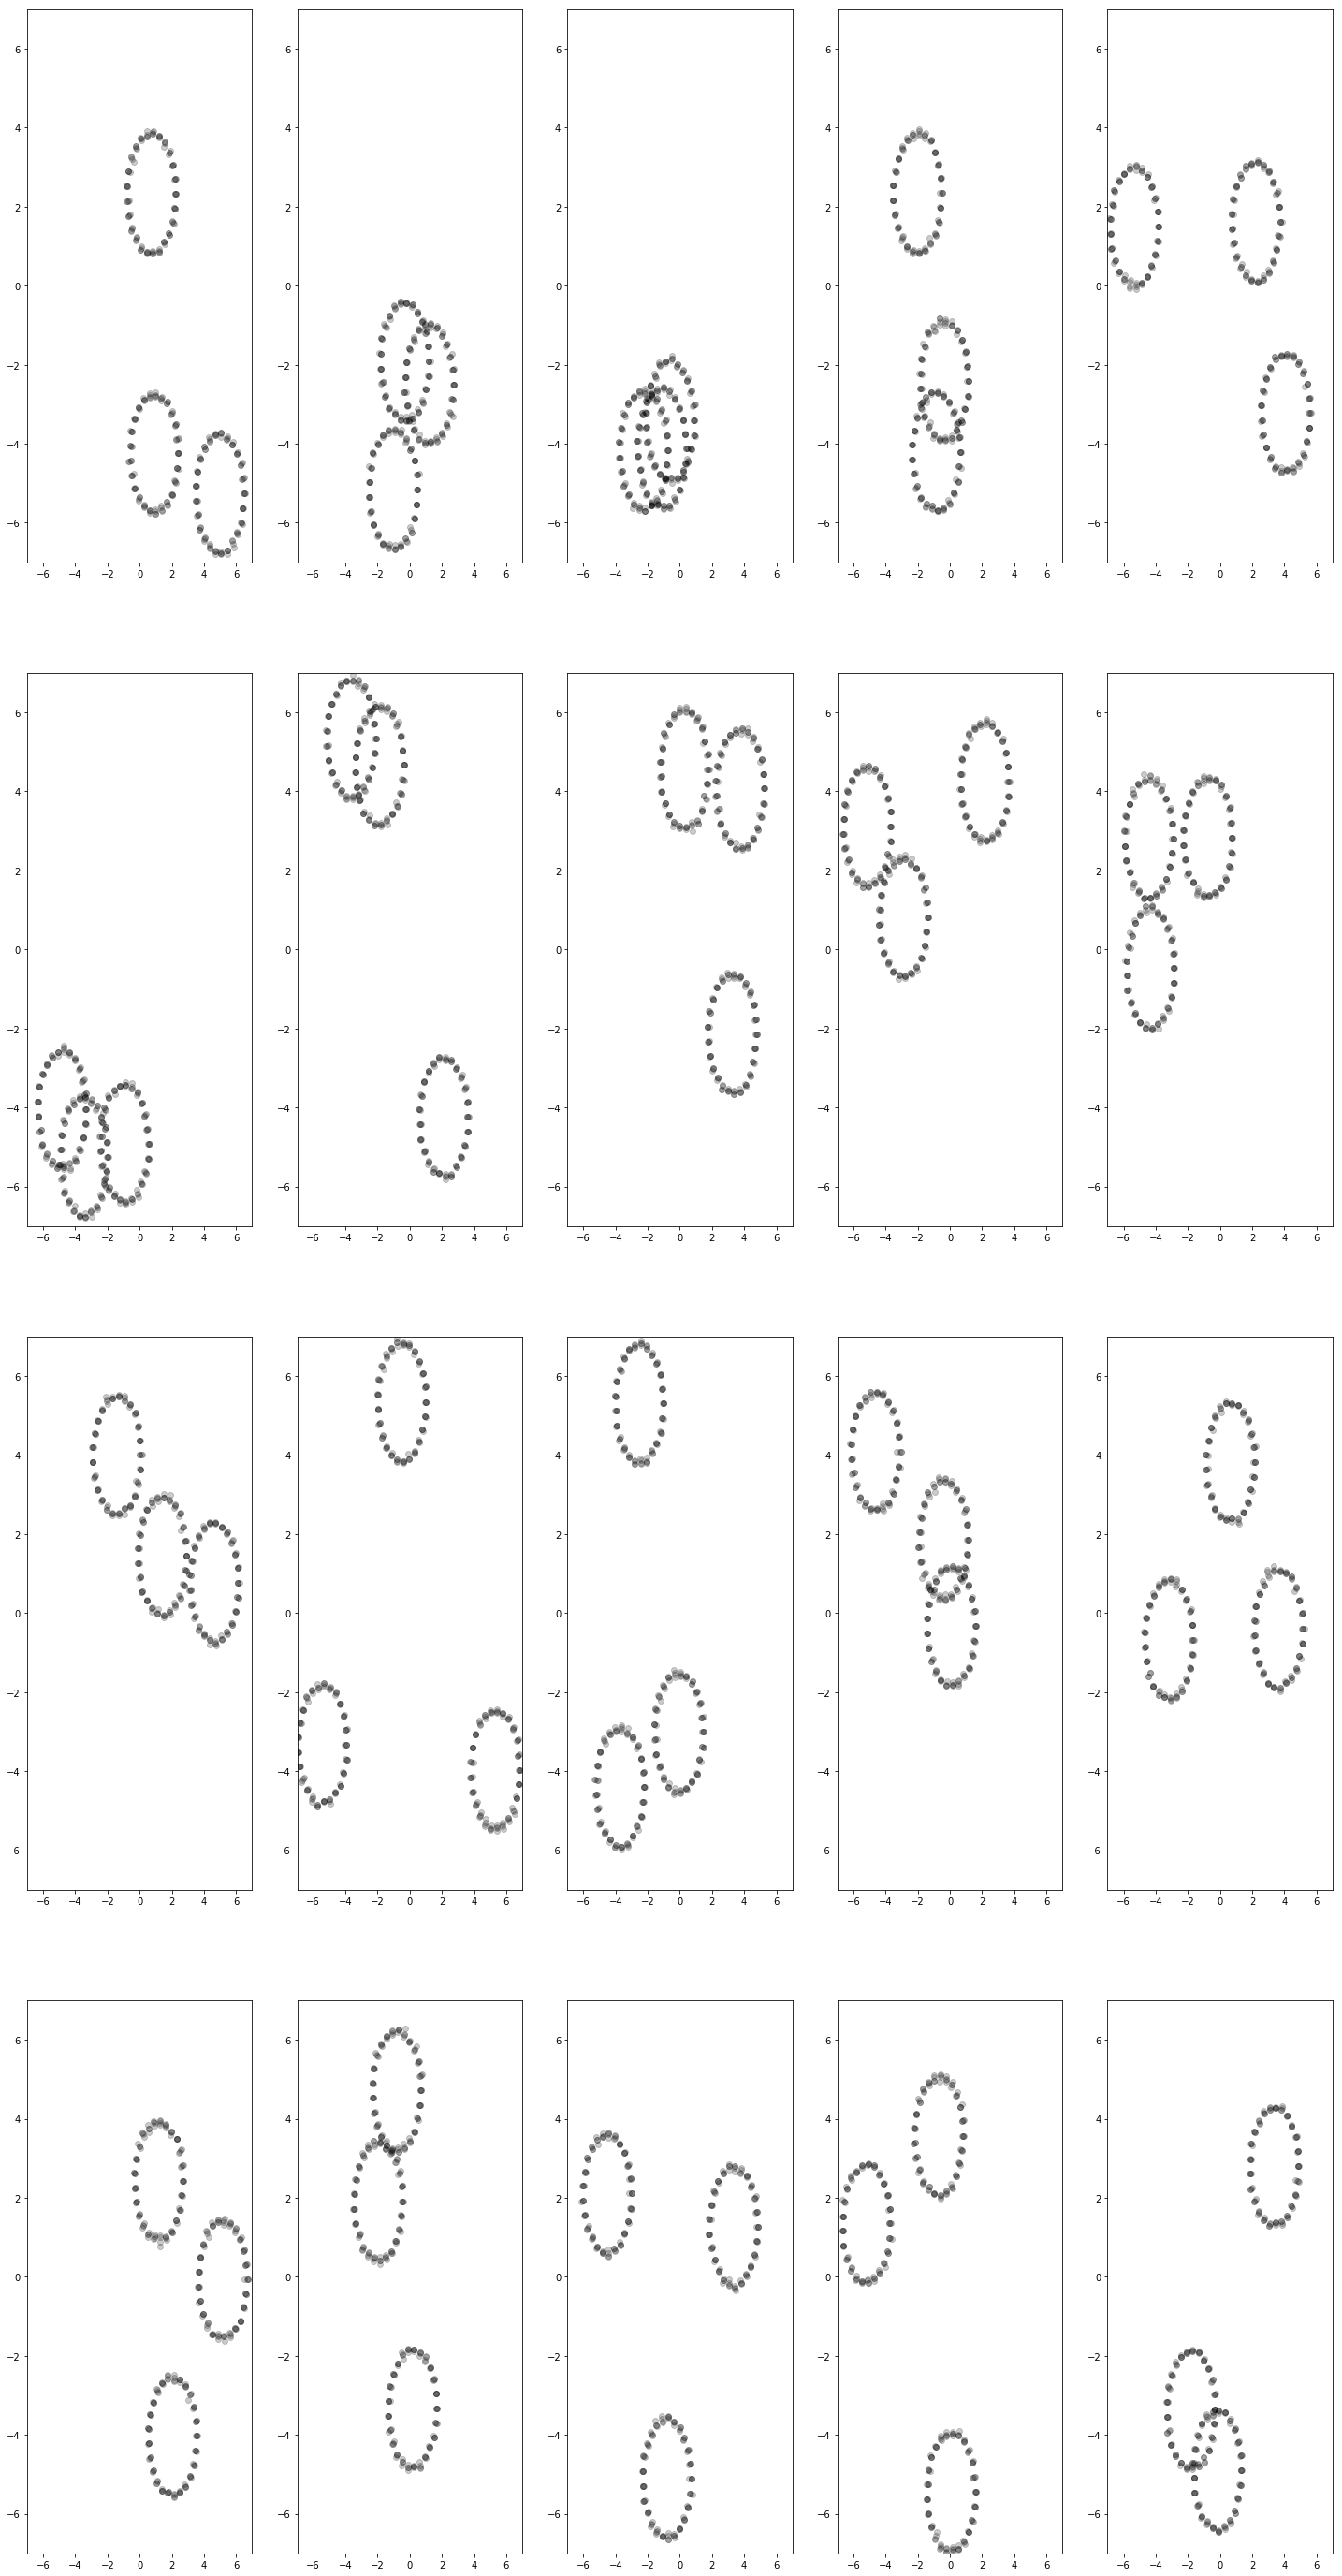

In [20]:
%time plot_samples(obs, x_recon, K, PATH)

In [ ]:
incremental_gap = symkls_test.cpu().data.numpy()[1:]
M = incremental_gap.shape[0]
overall_gap = np.zeros(M)
for m in range(M):
    overall_gap[m] = incremental_gap[:m+1].sum()

In [ ]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plt.yscale("log")
ax.plot(incremental_gap, label="incremental gap")
ax.plot(overall_gap, label='overall gap')
ax.legend(fontsize=14)
ax.set_xlabel('Steps')